In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from os import listdir

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd() # /home/swl/Mask_RCNN

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs") # /home/swl/Mask_RCNN/logs

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5") # /home/swl/Mask_RCNN/mask_rcnn_coco.h5

# Directory of images to train on
TRAIN_IMAGE_DIR = os.path.join(ROOT_DIR, "train")
VAL_IMAGE_DIR = os.path.join(ROOT_DIR, "val")
MASK_DIR = os.path.join(ROOT_DIR, "mask")

Using TensorFlow backend.


## Configurations

In [2]:
class StomachCancerConfig(Config):
    # Give the configuration a recognizable name
    NAME = "stomachcancer"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = StomachCancerConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           stomachcancer
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_RO

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class StomachCancerDataset(utils.Dataset):

    def load_stomachcancer(self, dataset_dir, subset, return_stomachcancer=False):

        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        class_ids: If provided, only loads images that have the given classes.
        return_coco: If True, returns the COCO object.
        """

        # Add classes
        self.add_class("stomachcancer", 1, "cancernest")
        #self.add_class("stomachcancer", 2, "benign")

        # Add images
        directorypath=os.path.join(dataset_dir, subset)
        file_names = next(os.walk(directorypath))[2]
        for fn in file_names:
            self.add_image("stomachcancer", image_id=fn.split(".")[0],
                           path=os.path.join(directorypath, fn),
                           width=config.IMAGE_SHAPE[1], height=config.IMAGE_SHAPE[0])
        
        if return_stomachcancer:
            return stomachcancer

    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]

        if info['path'].find('negative')>0:
            mask = np.ones([info['height'], info['width'], 1], dtype=np.uint8)
            #mask[:,1:512,0]=1;#mask[:,:,0]=1;mask[:,:,0]=1;mask[:,:,0]=1;
            class_ids = np.array([0])
        else:
            filename_list = listdir(MASK_DIR)
            for filename in filename_list:
                if filename.split('.')[0] == info['id']:
                    mask = np.load(os.path.join(MASK_DIR, filename))
                    class_ids = np.array([1 for num_nests in range(mask.shape[2])])
        return mask, class_ids

In [5]:
# Training dataset
dataset_train = StomachCancerDataset()
dataset_train.load_stomachcancer(TRAIN_IMAGE_DIR, "positive")
#dataset_train.load_stomachcancer(TRAIN_IMAGE_DIR, "negative")
dataset_train.prepare()

# Validation dataset
dataset_val = StomachCancerDataset()
dataset_val.load_stomachcancer(VAL_IMAGE_DIR, "positive")
dataset_val.load_stomachcancer(VAL_IMAGE_DIR, "negative")
dataset_val.prepare()

(1024, 1024, 9) [1 1 1 1 1 1 1 1 1]


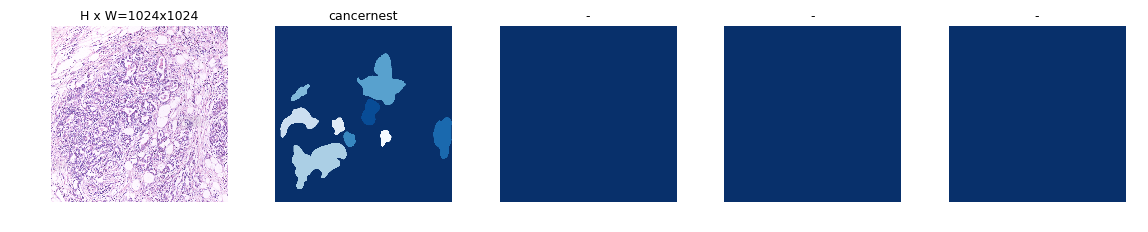

(1024, 1024, 8) [1 1 1 1 1 1 1 1]


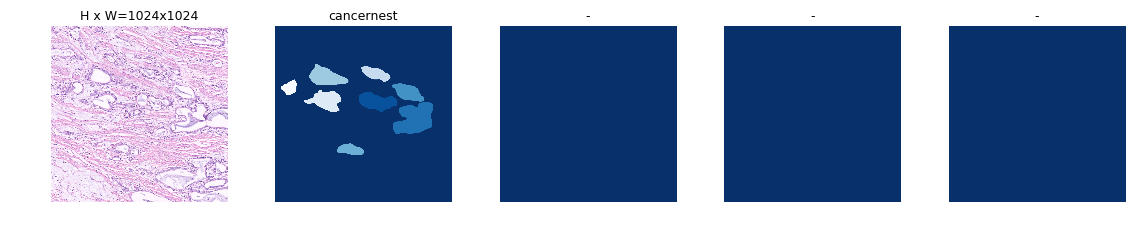

(1024, 1024, 11) [1 1 1 1 1 1 1 1 1 1 1]


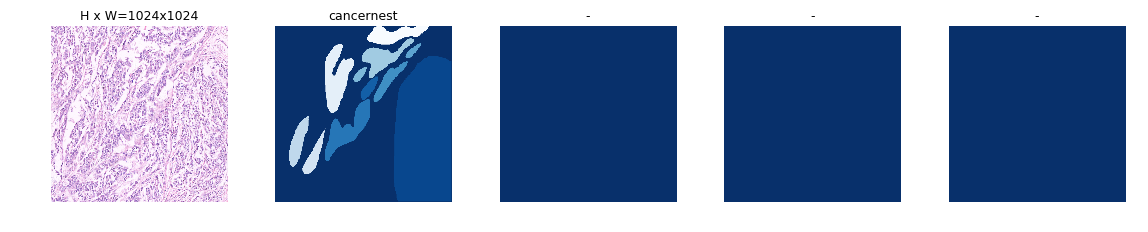

(1024, 1024, 4) [1 1 1 1]


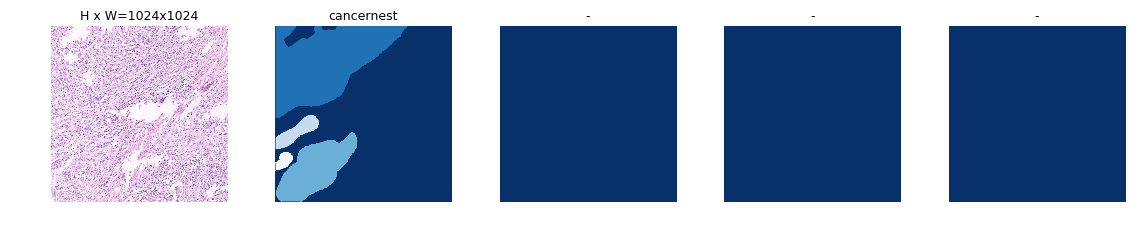

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape,class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

ERROR:root:Error processing image {'source': 'stomachcancer', 'height': 1024, 'width': 1024, 'path': '/home/swl/Mask_RCNN/val/positive/F5BEFE302A43D7237FBC12B9F1347235__flipv.tiff', 'id': 'F5BEFE302A43D7237FBC12B9F1347235__flipv'}
Traceback (most recent call last):
  File "/home/swl/Mask_RCNN/model.py", line 1604, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/swl/Mask_RCNN/model.py", line 1163, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-4-48f6a5be3ad6>", line 52, in load_mask
    return mask, class_ids
UnboundLocalError: local variable 'mask' referenced before assignment



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/swl/Mask_RCNN/logs/stomachcancer20180228T1554/mask_rcnn_stomachcancer_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed

/home/swl/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/swl/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 55s 555ms/step - loss: 3.7605 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 2.0933 - mrcnn_class_loss: 0.4217 - mrcnn_bbox_loss: 0.6663 - mrcnn_mask_loss: 0.4953 - val_loss: 3.2576 - val_rpn_class_loss: 0.0675 - val_rpn_bbox_loss: 1.1463 - val_mrcnn_class_loss: 0.5629 - val_mrcnn_bbox_loss: 0.8529 - val_mrcnn_mask_loss: 0.6280


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/swl/Mask_RCNN/logs/stomachcancer20180228T1554/mask_rcnn_stomachcancer_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2

ERROR:root:Error processing image {'source': 'stomachcancer', 'height': 1024, 'width': 1024, 'path': '/home/swl/Mask_RCNN/val/positive/E937F0F8AB6AD10F64D23DB5552AB45E__flipv.tiff', 'id': 'E937F0F8AB6AD10F64D23DB5552AB45E__flipv'}
Traceback (most recent call last):
  File "/home/swl/Mask_RCNN/model.py", line 1604, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/swl/Mask_RCNN/model.py", line 1163, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-4-48f6a5be3ad6>", line 52, in load_mask
    return mask, class_ids
UnboundLocalError: local variable 'mask' referenced before assignment
ERROR:root:Error processing image {'source': 'stomachcancer', 'height': 1024, 'width': 1024, 'path': '/home/swl/Mask_RCNN/val/positive/FA6C0BC12E476CCFA93848FC15195E0A__flipv.tiff', 'id': 'FA6C0BC12E476CCFA93848FC15195E0A__flipv'}
Traceback (most recent call last):
  File "/home/swl/Mask_RCNN/model.py", line 1604, in data_generator
    use_mini_ma

Epoch 2/2
 44/100 [============>.................] - ETA: 45s - loss: 2.8576 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.4828 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.5565 - mrcnn_mask_loss: 0.4596

ERROR:root:Error processing image {'source': 'stomachcancer', 'height': 1024, 'width': 1024, 'path': '/home/swl/Mask_RCNN/train/positive/0C82C47F4B586FA93961A8AC4141F741.tiff', 'id': '0C82C47F4B586FA93961A8AC4141F741'}
Traceback (most recent call last):
  File "/home/swl/Mask_RCNN/model.py", line 1604, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/swl/Mask_RCNN/model.py", line 1192, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/home/swl/Mask_RCNN/utils.py", line 438, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero


100/100 [==============================] - 71s 708ms/step - loss: 3.0459 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.6641 - mrcnn_class_loss: 0.3319 - mrcnn_bbox_loss: 0.5479 - mrcnn_mask_loss: 0.4614 - val_loss: 1.8656 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 0.8547 - val_mrcnn_class_loss: 0.1641 - val_mrcnn_bbox_loss: 0.4524 - val_mrcnn_mask_loss: 0.3815


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(StomachCancerConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/swl/Mask_RCNN/logs/stomachcancer20180228T1554/mask_rcnn_stomachcancer_0002.h5


original_image           shape: (1024, 1024, 3)       min:    0.12157  max:    1.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (1, 4)                min:    0.00000  max: 1024.00000
gt_bbox                  shape: (1, 4)                min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 1)       min:    1.00000  max:    1.00000


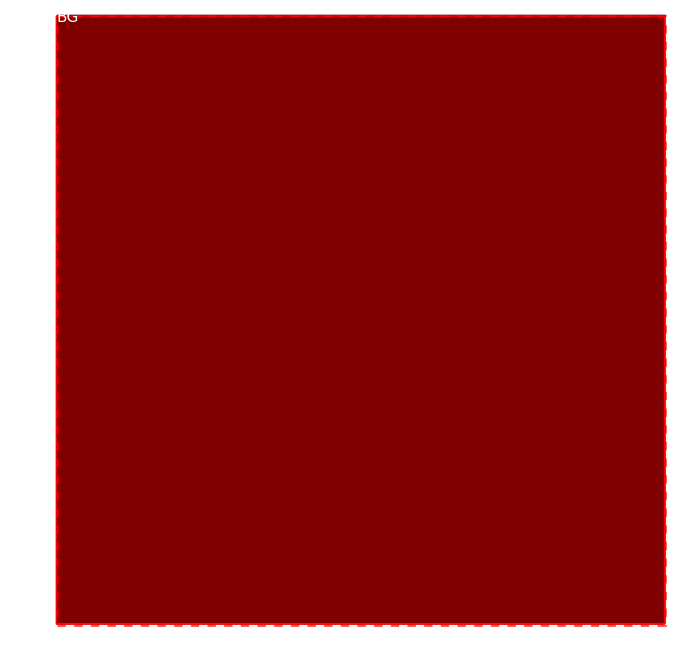

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.12157  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.52745  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000

*** No instances to display *** 



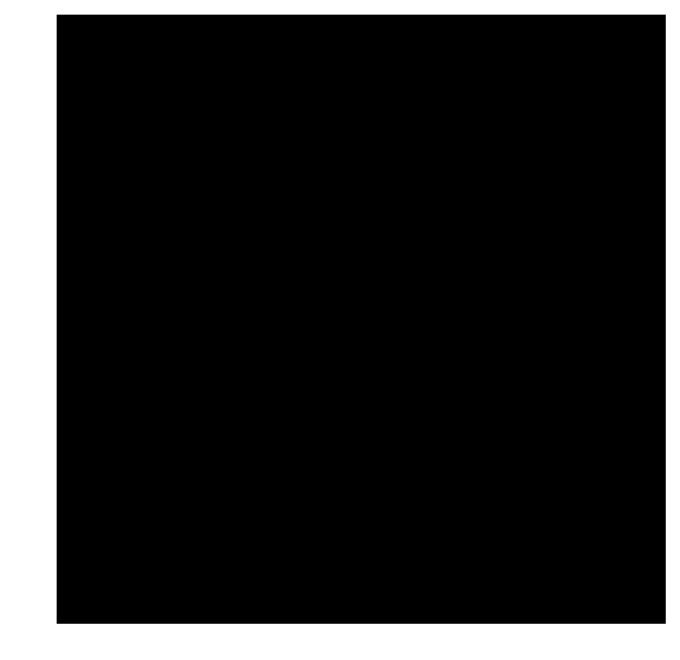

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.

#image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
# for image_id in image_ids:
print(len(dataset_val.image_ids))
for image_id in dataset_val.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

534


UnboundLocalError: local variable 'mask' referenced before assignment